# Notebook for benchmarking filtering on CPU

In [4]:
import numpy as np
import time
import tifffile
import scipy.signal
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [5]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [6]:
# open the file as a memmap 
file_path = "/home/clewis/repos/holo-nbs/rb26_20240111/raw_voltage_chunk.tif"
data = tifffile.memmap(file_path)
data.shape

(384, 3000001)

## Try filtering chunks of data via numpy

In [14]:
# define filter functions
def butter(cutoff, fs, order=5, btype='high'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a


def butter_filter(data, cutoff, fs, order=5, axis=-1, btype='high'):
    b, a = butter(cutoff, fs, order=order, btype=btype)
    y = scipy.signal.filtfilt(b, a, data, axis=axis)
    return y

In [45]:
latency = dict()
# try processing the first 100 5ms chunks of data
windows = [30, 150, 300, 750]
for j in windows:
    for i in range(1_000):
        ts = list()
        t = time.time()
        d = data[:, i:i + j]
        f = butter_filter(d, 1000, 30_000)
        ts.append(time.time() - t)
    latency[j] = sum(ts) / len(ts)

In [46]:
latency

{30: 0.0004353523254394531,
 150: 0.0008974075317382812,
 300: 0.00145721435546875,
 750: 0.003209352493286133}

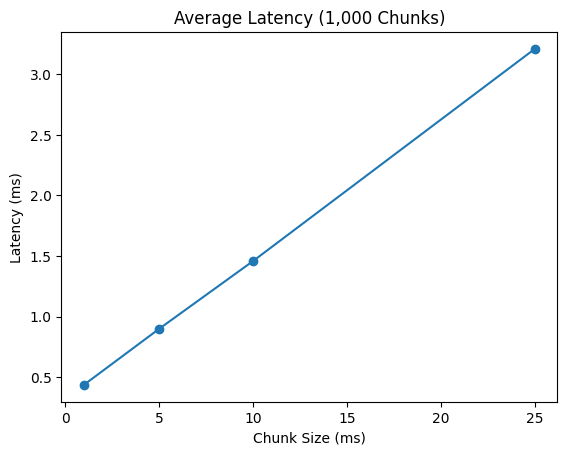

In [48]:


x_values = [a / 30 for a in list(latency.keys())] 
y_values = [a * 1000 for a  in list(latency.values())]

plt.plot(x_values, y_values, marker='o', linestyle='-')

plt.xlabel('Chunk Size (ms)')
plt.ylabel('Latency (ms)')
plt.title('Average Latency (1,000 Chunks)')

plt.show()

# Filter in frequency domain using jax

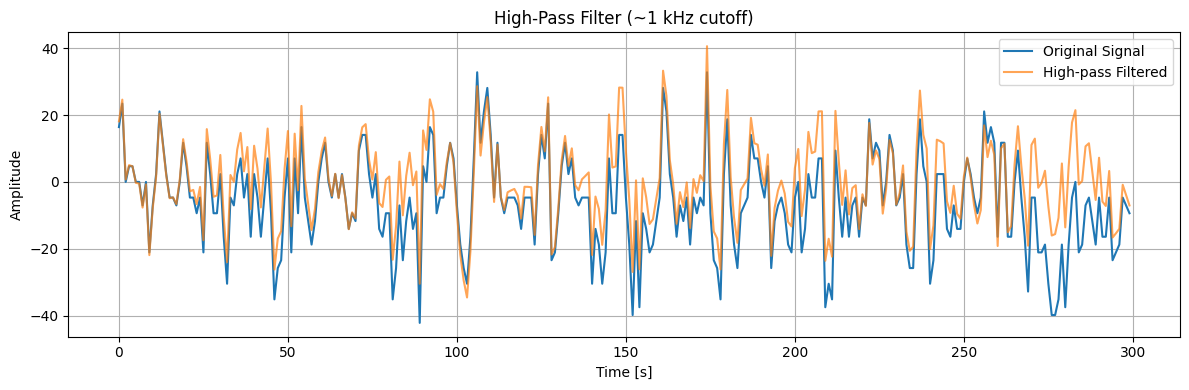

In [21]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax.numpy as jnp
import matplotlib.pyplot as plt

# Smaller signal to avoid memory issues
signal = data[0, :300]

n_samples = int(fs * duration)

fs = 30_000  # 30 kHz
duration = 0.01  # 10 ms

# FFT
freq_domain = jnp.fft.fft(signal)
freqs = jnp.fft.fftfreq(n_samples, d=1/fs)

t = jnp.linspace(0, duration, n_samples, endpoint=False)

# High-pass filter: cutoff at 1 kHz
cutoff = 1000
high_pass_mask = jnp.abs(freqs) > cutoff
filtered_freq_domain = freq_domain * high_pass_mask

# Inverse FFT to get filtered signal
filtered_signal = jnp.fft.ifft(filtered_freq_domain).real

f = butter_filter(signal, 1000, 30_000)

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(range(len(signal)), signal, label='Original Signal')
plt.plot(range(len(signal)), filtered_signal, label='High-pass Filtered', alpha=0.7)
# plt.plot(range(len(f)), f, "red", alpha = 0.7)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('High-Pass Filter (~1 kHz cutoff)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
import time

In [43]:
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax.numpy as jnp
import matplotlib.pyplot as plt

# Parameters
fs = 30_000  # Sampling rate
duration = 0.01  # 10 ms
n_samples = int(fs * duration)
n_channels = 384  # Number of channels

# Time vector
t = jnp.linspace(0, duration, n_samples, endpoint=False)

# Simulated multichannel signal: shape [n_channels, n_samples]
# Each channel has a mix of low and high frequencies
signals = data[:,:300]

t = time.time()
# FFT over axis=1 (samples)
freq_domain = jnp.fft.fft(signals, axis=1)
freqs = jnp.fft.fftfreq(n_samples, d=1/fs)

# High-pass filter mask: shape [n_samples]
cutoff = 1000
high_pass_mask = jnp.abs(freqs) > cutoff  # shape [n_samples]

# Broadcast mask to all channels: shape [n_channels, n_samples]
filtered_freq_domain = freq_domain * high_pass_mask  # broadcasted automatically

# Inverse FFT
filtered_signals = jnp.fft.ifft(filtered_freq_domain, axis=1).real

print(time.time() - t)

# Plot example channel
# plt.figure(figsize=(12, 4))
# plt.plot(t, signals[1], label='Original Ch 0')
# plt.plot(t, filtered_signals[1], label='Filtered Ch 0')
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude")
# plt.title("High-Pass Filter on Channel 0")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

0.003624439239501953
